In [1]:
import sys
# !{sys.executable} -m pip install pennylane pennylane-qiskit pennylane-qulacs --force-reinstall
from glob import glob
from pennylane import numpy as np
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeQuebec
from quantum.Evaluate import evaluate
from scipy.optimize import minimize, basinhopping
from settings import ANSATZ_LIST, ENCODER_LIST
from shutil import copy,SameFileError
from sklearn.exceptions import InconsistentVersionWarning
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.utils._testing import ignore_warnings
from quantum.circuits.Encoders import iqp_embedding
from tqdm import tqdm
import click
import collections.abc
import itertools
import joblib
import json
import matplotlib.pyplot as plt
import mthree
import numpy as np
import os
import pandas as pd
import pennylane as qml
import time
import dill
from pennylane_qiskit import qiskit_session




In [2]:
class BasinBounds:
    def __init__(self, xmax=np.pi, xmin=-np.pi):
        self.xmax = xmax
        self.xmin = xmin

    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        return tmax and tmin


class QuantumRegressor:
    """
    Machine learning model based on quantum circuit learning.

    Methods
    ------
    fit(x, y, initial_parameters=None, detailed_results=False, load_state=None, callback_interval=None)
        Fits the model instance to the given x and y data.
    predict(x)
        Predicts y values for a given array of input data based on previous training.

    """

    def __init__(
            self,
            encoder,
            variational,
            num_qubits,
            optimizer: str = 'COBYLA',
            max_iterations: int = None,
            tol: float = 1e-8,
            device: str = 'default.qubit',
            backend: str = None,
            postprocess: str = None,
            error_mitigation=None,
            shots: int = None,
            re_upload_depth: int = 1,
            f: float = 1.,
            alpha: float = 0.,
            beta: float = 0,
            token: str = None,
            batch_size: int=None,
            njobs: int=None):
        self.hyperparameters = {'f': f, 'alpha': alpha, 'beta': beta}
        self.callback_interval = None
        self.x = None
        self.y = None
        self.params = None
        self._batch_size = batch_size
        self._re_upload_depth = re_upload_depth
        self.error_mitigation = error_mitigation
        self.num_qubits = num_qubits
        self.max_iterations = max_iterations
        if postprocess == 'None':
            postprocess = None
        self.postprocess = postprocess
        self.encoder = encoder
        self.variational = variational     
        self._set_device(device, backend, shots, token)
        self._set_optimizer(optimizer)
        self._tol = tol
        self._build_qnode()
        self.fit_count = 0
        self.cached_results = {}
        self.njobs = njobs 
        print(self.njobs)
        os.environ["OMP_NUM_THREADS"] = str(self.njobs)
        print(os.environ["OMP_NUM_THREADS"])
    def _set_device(self, device, backend, shots, token=None):
        #  sets the models quantum device. If using IBMQ asks for proper credentials
        if device == 'qiskit.remote':
            print('Running on IBMQ Runtime')
            service = QiskitRuntimeService(channel="ibm_quantum", instance='pinq-quebec-hub/univ-toronto/default')
            self._backend = service.least_busy(operational=True, simulator=False, min_num_qubits=self.num_qubits)
            if self.error_mitigation == 'TREX':
                self.device = qml.device("qiskit.remote", backend=self._backend, wires=127,shots=shots,resilience_level=1,optimization_level=0,seed_transpiler=42)
            if self.error_mitigation == 'ZNE':
                self.device = qml.device("qiskit.remote", backend=self._backend, wires=127,shots=shots,resilience_level=2,optimization_level=0,seed_transpiler=42)                
            else:
                self.device = qml.device("qiskit.remote", backend=self._backend, wires=127,shots=shots,resilience_level=0,optimization_level=0,seed_transpiler=42)
            
        elif device == 'qiskit.aer' and backend == "fake":
            # Example based on https://pennylane.ai/qml/demos/tutorial_error_mitigation/
            
            # A simple test for state vector simulation self.device = qml.device(device, backend=AerSimulator(), wires=self.num_qubits,shots=shots)
            service = QiskitRuntimeService(channel="ibm_quantum", instance='pinq-quebec-hub/univ-toronto/default')
            device_backend = service.least_busy(operational=True, simulator=False, min_num_qubits=self.num_qubits)
            self._backend=AerSimulator.from_backend(device_backend)
            if self.error_mitigation == 'TREX':
                self.device = qml.device("qiskit.remote", backend=self._backend, wires=127,shots=shots,resilience_level=1,optimization_level=0,seed_transpiler=42)
            if self.error_mitigation == 'ZNE':
                self.device = qml.device("qiskit.remote", backend=self._backend, wires=127,shots=shots,resilience_level=2,optimization_level=0,seed_transpiler=42)                
            else:
                self.device = qml.device("qiskit.remote", backend=self._backend, wires=127,shots=shots,resilience_level=0,optimization_level=0,seed_transpiler=42)
            

            # device_backend = FakeQuebec()
            # backend = AerSimulator.from_backend(device_backend)
            # print(backend.name)
            # noise_model = NoiseModel.from_backend(backend)
            # self._backend=backend
            # self.device = qml.device(device, backend=self._backend, wires=self.num_qubits, noise_model=noise_model,shots=shots,optimization_level=self.optimization_level)
            # self.device.set_transpile_args(**{'resilience_level': 0})


            # if self.error_mitigation == 'TREX':
            #     self.device.set_transpile_args(**{'resilience_level': 1})
        else:
            self.device = qml.device(device, wires=self.num_qubits, shots=shots)

    def _set_optimizer(self, optimizer):
        #  sets the desired optimizer. SPSA is not available in scipy and has to be handled separately in fitting
        if optimizer == 'SPSA':
            self.use_scipy = False
            self.optimizer = optimizer
        elif optimizer == 'BasinHopping':
            self.use_scipy = False
            self.optimizer = optimizer
        else:
            self.use_scipy = True
            self.optimizer = optimizer

    def _circuit(self, features, parameters):
        #  builds the circuit with the given encoder and variational circuits.
        #  encoder and variational circuits must have only two required parameters, params/feats and wires
        for i in range(self._re_upload_depth):
            params = parameters[self._num_params() * i:self._num_params() * (i + 1)]
            self.encoder(features, wires=range(self.num_qubits))
            # GMJ: 11/26/24 a hack to get this to work for Full-CRZ/X
            try:
                self.variational(params, wires=range(self.num_qubits))
            except:
                self.variational(params, wires=range(self.num_qubits))

        if self.postprocess is None:
            return qml.expval(qml.PauliZ(0))
        elif self.postprocess is not None:
            return [qml.expval(qml.PauliZ(i)) for i in range(self.num_qubits)]

    def _build_qnode(self):
        #  builds QNode from device and circuit using mitiq error mitigation if specified.
        self.qnode = qml.QNode(self._circuit, self.device)

    def _cost(self, parameters):
        # GMJ Batch loss
        if self._batch_size is not None and self.njobs is not None:
            batch_partitions = np.array_split(np.random.randint(0, len(self.x), len(self.x)),len(self.x)//self._batch_size)
            base_cost = np.mean(joblib.Parallel(n_jobs=self.njobs,verbose=0)(joblib.delayed(mean_squared_error)(self.y[i], self.predict(self.x[i], params=parameters)) for i in tqdm(batch_partitions,desc=f"Cost (Batches {len(batch_partitions)} of size {self._batch_size})")))
        else:
            pred = np.array(self.predict(self.x, params=parameters)).reshape(*self.y.shape)
            base_cost = mean_squared_error(self.y, pred)        
            
        
        if self.postprocess is None or self.postprocess == 'None' or self.postprocess == 'simple':
            return base_cost
        elif self.postprocess == 'ridge':
            extra_params = parameters[-self.num_qubits:]
            alpha = self.hyperparameters['alpha']

            return base_cost + alpha * np.linalg.norm(extra_params)
        elif self.postprocess == 'lasso':
            extra_params = parameters[-self.num_qubits:]
            alpha = self.hyperparameters['alpha']

            l1_norm = 0
            for param in extra_params:
                l1_norm += np.abs(param)

            return base_cost + alpha * l1_norm
        elif self.postprocess == 'elastic':
            extra_params = parameters[-self.num_qubits:]
            alpha = self.hyperparameters['alpha']
            beta = self.hyperparameters['beta']

            l1_norm = 0
            for param in extra_params:
                l1_norm += np.abs(param)

            return base_cost + beta * (alpha * l1_norm + (1 - alpha) * np.linalg.norm(extra_params))
        else:
            raise NotImplementedError(f'The given postprocess type {self.postprocess} is not implemented. ')

    def _cost_wrapper(self, parameters):
        # caches the results from the cost function, so they don't have to be recalculated if they get called again i.e.
        # during the callback function for logging.
        param_hash = hash(parameters.data.tobytes())
        if param_hash in self.cached_results:
            cost = self.cached_results[param_hash]
        else:
            cost = self._cost(parameters)
            self.cached_results[param_hash] = cost

        cost = np.array(cost)
        return cost

    def _num_params(self):
        #  computes the number of parameters required for the implemented variational circuit
        num_params = self.variational.num_params
        return num_params

    def _callback(self, xk):
        cost_at_step = self._cost_wrapper(xk)            
        if self.fit_count % 1 == 0:
            print(f'[{time.asctime()}]  Iteration number: {self.fit_count} with current cost as {cost_at_step} and '
                  f'parameters \n{xk}. ')
        filename = 'model_log.csv'
        log = f'{time.asctime()},{self.fit_count},{cost_at_step},{xk}'
        with open(filename, 'a') as outfile:
            outfile.write(log)
            outfile.write('\n')
        self.fit_count += 1
        self._save_partial_state(xk)

    def _save_partial_state(self, param_vector, force=False):
        # saves every call to a bin file able to be loaded later by calling fit with load_state set to filename
        interval = self.callback_interval
        if interval is None:
            interval = 5
        if self.fit_count % interval == 0 or force:
            partial_results = {
                'parameters': np.array(param_vector),
                'iterations': self.fit_count
            }
            if force is True and os.path.exists('partial_state_model.bin'):
                outfile = 'final_state_model.bin'
                os.remove('partial_state_model.bin')
            else:
                outfile = 'partial_state_model.bin'
            
            joblib.dump(partial_results, outfile)

    def _load_partial_state(self, infile):
        print('Loading partial state from file ' + infile)
        partial_state = joblib.load(infile)
        if type(partial_state) == dict:
            param_vector = partial_state['parameters']
            iteration = partial_state['iterations']
            print('Loaded parameter_vector as', param_vector)
            return param_vector, iteration
        else:
            print('Outdated partial file detected! Unexpected behaviour may occur.')
            param_vector = partial_state
            print('Loaded parameter_vector as', param_vector)
        return param_vector, 0

    def fit(self, x, y, initial_parameters=None, detailed_results=False, load_state=None, callback_interval=None):
        """
        Fits the current model to the given x and y data. If no initial parameters are given then random ones will be
        chosen. Optimal parameters are stored in the model for use in predict and returned in this function.

        :param x: np.array
            x data to fit
        :param y: np.array
            y data to fit
        :param initial_parameters: list, optional
            initial parameters to start optimizer
        :param detailed_results: bool, optional
            whether to return detailed results of optimization or just parameters
        :param load_state: str, optional
            file to load partial fit data from
        :param callback_interval: int, optional
            how often to save the optimization steps to file
        :return:
            returns the optimal parameters found by optimizer. If detailed_results=True and optimizer is scipy, then
            will be of type scipy optimizer results stored in dictionary.
        """
        self.fit_count = 0
        with open('model_log.csv', 'w') as outfile:
            outfile.write('Time,Iteration,Cost,Parameters')
            outfile.write('\n')
        self.callback_interval = callback_interval

        if load_state is not None:
            param_vector, self.fit_count = self._load_partial_state(load_state)
            initial_parameters = param_vector
        elif initial_parameters is None:
            num_params = self._num_params() * self._re_upload_depth
            generator = np.random.default_rng(12958234)
            initial_parameters = generator.uniform(-np.pi, np.pi, num_params)
            if self.postprocess is not None:
                additional_num_params = self.num_qubits
                additional_params = generator.uniform(-1, 1, additional_num_params)
                initial_parameters = np.concatenate((initial_parameters, additional_params))
        self.x = x
        self.y = y
        params = initial_parameters
            
        try:
            with qiskit_session(self.device) as session:
                print("Session details: ",session)
                if self.use_scipy:
                    options = {
                        'maxiter': self.max_iterations - self.fit_count,
                        'tol': self._tol,
                        'disp': True
                    }
                    opt_result = minimize(self._cost_wrapper, x0=params, method=self.optimizer, callback=self._callback, options=options)
                    self.params = opt_result['x']
                elif self.optimizer == 'BasinHopping':
                    minimizer_kwargs = {"method": "BFGS"}
                    opt_result = basinhopping(self._cost_wrapper, x0=params, minimizer_kwargs=minimizer_kwargs,
                                              accept_test=BasinBounds(xmax=np.pi, xmin=-np.pi), niter=self.max_iterations,
                                              callback=self._callback)
                    self.params = opt_result['x']
                else:
           
                    opt = qml.SPSAOptimizer(maxiter=self.max_iterations)
                    cost = []
                    for idx,_ in enumerate(range(self.max_iterations)):
                        params, temp_cost = opt.step_and_cost(self._cost_wrapper, params)
                        cost.append(temp_cost)
                        self._callback(params)
        
                        if idx>0 and abs(cost[idx]-cost[idx-1])<=self._tol and abs(np.mean(cost[-3:])-temp_cost)<=self._tol:
                            print("Early stopping!")
                            break
                            
                    opt_result = [params, cost]
                    self.params = params                    

        except:
            if self.use_scipy:
                options = {
                    'maxiter': self.max_iterations - self.fit_count,
                    'tol': self._tol,
                    'disp': True
                }
                opt_result = minimize(self._cost_wrapper, x0=params, method=self.optimizer, callback=self._callback, options=options)
                self.params = opt_result['x']
            elif self.optimizer == 'BasinHopping':
                minimizer_kwargs = {"method": "BFGS"}
                opt_result = basinhopping(self._cost_wrapper, x0=params, minimizer_kwargs=minimizer_kwargs,
                                          accept_test=BasinBounds(xmax=np.pi, xmin=-np.pi), niter=self.max_iterations,
                                          callback=self._callback)
                self.params = opt_result['x']
            else:
       
                opt = qml.SPSAOptimizer(maxiter=self.max_iterations)
                cost = []
                for idx,_ in enumerate(range(self.max_iterations)):
                    params, temp_cost = opt.step_and_cost(self._cost_wrapper, params)
                    cost.append(temp_cost)
                    self._callback(params)
    
                    if idx>0 and abs(cost[idx]-cost[idx-1])<=self._tol and abs(np.mean(cost[-3:])-temp_cost)<=self._tol:
                        print("Early stopping!")
                        break
                        
                opt_result = [params, cost]
                self.params = params                    
            

        self._save_partial_state(params, force=True)
        if detailed_results:
            for key, value in opt_result.items():
                if type(value) is np.ndarray:
                    value = value.tolist()
                    for i, x in enumerate(value):
                        if type(x) is np.bool_:
                            value[i] = bool(x)
                    opt_result[key] = value
                elif type(value) is np.bool_:
                    value = bool(value)
                    opt_result[key] = value
            with open('detailed_results.json', 'w') as outfile:
                try:
                    json.dump(opt_result, outfile)
                except:
                    print('Could not dump detailed results. Not json serializable. ')
        return self.params

    def predict(self, x, params=None,evaluate=False):
        """
        Predicts a set of output data given a set of input data x using the trained parameters found with fit

        :param x: np.array
            x data to predict outputs of in the model
        :param params: list
            optional parameters to use in prediction, used for internal cost functions.
        :raises ValueError:
            if fit is not first called then raises error explaining that the model must first be trained
        :return: np.ndarray
            predicted values corresponding to each datapoint in x
        """

        if evaluate==True:
            try:
                with qiskit_session(self.device) as session:
                    print("Session details: ",session)
                    f = self.hyperparameters['f']
                    if params is None:
                        # if no parameters are passed then we are predicting the fitted model, so we use the stored parameters.
                        params = self.params
            
                    if self.postprocess is None:
                        return [f * self.qnode(features=features, parameters=params) for features in tqdm(x,desc="Predict")]
                    else:
                        return [np.dot(f * np.array(self.qnode(features=features, parameters=params[:-self.num_qubits])),params[-self.num_qubits:]) for features in x]                 
            except:
                f = self.hyperparameters['f']
                if params is None:
                    # if no parameters are passed then we are predicting the fitted model, so we use the stored parameters.
                    params = self.params
        
                if self.postprocess is None:
                    return [f * self.qnode(features=features, parameters=params) for features in tqdm(x,desc="Predict")]
                else:
                    return [np.dot(f * np.array(self.qnode(features=features, parameters=params[:-self.num_qubits])),params[-self.num_qubits:]) for features in x]
                

        else:
            f = self.hyperparameters['f']
            if params is None:
                # if no parameters are passed then we are predicting the fitted model, so we use the stored parameters.
                params = self.params
    
            if self.postprocess is None:
                return [f * self.qnode(features=features, parameters=params) for features in tqdm(x,desc="Predict")]
            else:
                return [np.dot(f * np.array(self.qnode(features=features, parameters=params[:-self.num_qubits])),params[-self.num_qubits:]) for features in x]


In [3]:
def evaluate_1d(model, X_train, X_test, y_train, y_test, plot=True, title=""):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    scores = {'MSE_train': mean_squared_error(y_train, y_train_pred),
              'MSE_test': mean_squared_error(y_test, y_test_pred),
              'R2_train': r2_score(y_train, y_train_pred),
              'R2_test': r2_score(y_test, y_test_pred)
              }
    if plot:
        plt.title(title)
        plt.scatter(X_train, y_train_pred, color='b', label='Train', s=10)
        plt.scatter(X_test, y_test_pred, color='orange', label='Test', s=10)
        plt.scatter(X_train, y_train, color='green', label='Data', s=10)
        plt.scatter(X_test, y_test, color='green', s=10)
        plt.legend()
    return scores


def evaluate(model, X_train, y_train, X_test=None, y_test=None, plot: bool = False, title: str = 'defult',
             y_scaler=None):
    scores = {}
    st = time.time()
    print('Now scoring model... ')
    y_train_pred = np.array(model.predict(X_train,evaluate=True))
    y_train_pred = y_scaler.inverse_transform(y_train_pred.reshape(-1, 1))
    y_train = y_scaler.inverse_transform(y_train.reshape(-1, 1))

    scores['MSE_train'] = mean_squared_error(y_train, y_train_pred),
    scores['R2_train'] = r2_score(y_train, y_train_pred)
    scores['MAE_train'] = mean_absolute_error(y_train, y_train_pred)

    y_test_pred = None
    y_test = y_scaler.inverse_transform(y_test.reshape(-1, 1))
    if y_test is not None:
        y_test_pred = np.array(model.predict(X_test,evaluate=True))
        y_test_pred = y_scaler.inverse_transform(y_test_pred.reshape(-1, 1))
        scores['MSE_test'] = mean_squared_error(y_test, y_test_pred)
        scores['R2_test'] = r2_score(y_test, y_test_pred)
        scores['MAE_test'] = mean_absolute_error(y_test, y_test_pred)

    if plot:
        plt.figure()
        if y_test_pred is not None:
            plt.scatter(y_test, y_test_pred, color='b', s=10, label=f'Test, MAE = {scores["MAE_test"]:.2f}')
        plt.scatter(y_train, y_train_pred, color='r', s=10, label=f'Train, MAE = {scores["MAE_train"]:.2f}')
        plt.ylabel('Predicted')
        plt.xlabel('Actual')
        plt.axis('scaled')

        max_val = max(max(plt.xlim()), max(plt.ylim()))
        plt.xlim((0, max_val))
        plt.ylim((0, max_val))

        x_min, x_max = plt.xlim()
        y_min, y_max = plt.ylim()
        plt.plot([x_min, x_max], [y_min, y_max], 'k--', alpha=0.2, label='y=x')
        plt.legend()
        plt.savefig(title+'_plot.svg')

        if X_test.shape[1] == 1:
            plt.figure()
            plt.title(title)
            plt.scatter(X_train, y_train_pred, color='b', label='Train', s=10)
            plt.scatter(X_test, y_test_pred, color='orange', label='Test', s=10)
            plt.scatter(X_train, y_train, color='green', label='Data', s=10)
            plt.scatter(X_test, y_test, color='green', s=10)
            plt.legend()
            plt.savefig(title+'_1D_plot.svg')

    print(f'Scoring complete taking {time.time() - st} seconds. ')

    return scores, y_test_pred, y_train_pred


In [4]:

# Global variables
OPTIMIZER = None
SHOTS = None
X_DIM = None
BACKEND = None
DEVICE = None
ANSATZ = None
ENCODER = None
POSTPROCESS = None
ERROR_MITIGATION = None
LAYERS = None
TOKEN = None
HYPERPARAMETERS = None
RE_UPLOAD_DEPTH = None
MAX_ITER = None
TOLERANCE = None
NUM_QUBITS = None
BATCH_SIZE = None
NUM_CORES = None
############################################
# Utility functions
############################################


def parse_settings(settings_file):
    with open(settings_file, 'r') as fp:
        settings = json.load(fp)

    global OPTIMIZER
    OPTIMIZER = settings['OPTIMIZER']

    global SHOTS
    SHOTS = settings['SHOTS']
                
    global BACKEND
    BACKEND = settings['BACKEND']

    global DEVICE
    DEVICE = settings['DEVICE']

    global POSTPROCESS
    POSTPROCESS = settings['POSTPROCESS']

    global ERROR_MITIGATION
    ERROR_MITIGATION = settings['ERROR_MITIGATION']

    global LAYERS
    LAYERS = settings['LAYERS']

    global HYPERPARAMETERS
    HYPERPARAMETERS = settings['HYPERPARAMETERS']
    # f was removed from HYPERPARAMETERS, this ensures old settings files can still run.
    if 'f' in HYPERPARAMETERS.keys():
        _ = HYPERPARAMETERS.pop('f', None)

    global RE_UPLOAD_DEPTH
    RE_UPLOAD_DEPTH = settings['RE-UPLOAD_DEPTH']

    global MAX_ITER
    MAX_ITER = settings['MAX_ITER']

    global TOLERANCE
    try:
        TOLERANCE = settings['TOLERANCE']
    except KeyError:
        TOLERANCE = None

    global NUM_QUBITS
    try:
        NUM_QUBITS = settings['NUM_QUBITS']
    except KeyError:
        NUM_QUBITS = None

    # classes aren't JSON serializable, so we store the key in the settings file and access it here.
    global ANSATZ
    ANSATZ = ANSATZ_LIST[settings['ANSATZ']]

    global ENCODER
    ENCODER = ENCODER_LIST[settings['ENCODER']]

    global BATCH_SIZE
    BATCH_SIZE = settings['BATCH_SIZE']
    
    global NUM_CORES
    NUM_CORES = settings['NUM_CORES']

def load_dataset(file):
    print(f'Loading dataset from {file}... ')
    data = joblib.load(file)
    X = data['X']
    y = data['y']

    global X_DIM
    _, X_DIM = X.shape
    print(f'Successfully loaded {file} into X and y data. ')
    return X, y


def save_token(instance, token):
    global TOKEN
    TOKEN = token
    QiskitRuntimeService.save_account(channel='ibm_quantum', instance=instance, token=token, overwrite=True)




In [5]:


def plot_circuits(title):
    draw_ansatz = qml.draw_mpl(ANSATZ)
    draw_ansatz(np.random.rand(ANSATZ.num_params))
    plt.savefig(title + '_ansatz.svg')

    draw_encoder = qml.draw_mpl(ENCODER)
    draw_encoder(np.random.rand(X_DIM), range(X_DIM))
    plt.savefig(title + '_encoder.svg')


def create_kwargs():
    #  First have to apply specific ansatz settings: setting number of layers and the number of wires based on features
    ANSATZ.layers = LAYERS
    ANSATZ.set_wires(range(X_DIM))

    kwargs = {
        'encoder': ENCODER,
        'variational': ANSATZ,
        'num_qubits': X_DIM,
        'optimizer': OPTIMIZER,
        # 'optimizer': "BFGS",
        'max_iterations': MAX_ITER,
        'tol': TOLERANCE,
        'device': DEVICE,
        'shots': SHOTS,
        'backend': BACKEND,
        'postprocess': POSTPROCESS,
        'error_mitigation': ERROR_MITIGATION,
        'token': TOKEN,
        're_upload_depth': RE_UPLOAD_DEPTH,
        'batch_size': BATCH_SIZE,
        'njobs':NUM_CORES
    }
    return kwargs




In [6]:
# settings="./IQP_Full-Pauli-CRZ/qulacsIQP_Full-Pauli-CRZ.json" 
# settings="./IQP_Full-Pauli-CRZ/fakeIQP_Full-Pauli-CRZ.json" 
settings="./IQP_Full-Pauli-CRZ/IQP_Full-Pauli-CRZ.json" 
save_path='./IQP_Full-Pauli-CRZ'
train_set="0.1_linear_train.bin"
scaler="linear_scaler.bin" 
test_set="linear_test.bin" 
resume_file=os.path.join(os.path.expanduser('~'),"qregress/function-calc-test/learning_curves/linear/0.1/IQP_Full-Pauli-CRZ/final_state_model.bin")
title="IQP_Full-Pauli-CRZ"
save_circuits=False

### Write a function that runs training in a session but model evaluation prediction in a session also

In [7]:
"""
Trains the quantum regressor with the settings in the given settings file using the dataset from the given train
and test files. Will perform grid search on a default hyperparameter space unless they are specified. Saves scores
and best hyperparameters to joblib dumps and graphs of performance and circuit drawings as mpl svg.
"""
X_train, y_train = load_dataset(train_set)
parse_settings(settings)
if DEVICE == 'qiskit.ibmq':
    save_token(instance, token)

global NUM_QUBITS
global X_DIM

if NUM_QUBITS is not None:
    X_DIM = NUM_QUBITS
elif X_DIM == 1:  # if X_DIM is None and num_qubits wasn't specified anywhere use a default value of 2.
    NUM_QUBITS = 2
    X_DIM = NUM_QUBITS

kwargs = create_kwargs()

if title is None:
    title = os.path.basename(settings)
    title, _ = os.path.splitext(title)

if save_circuits:
    plot_circuits(title)

if test_set is not None:
    X_test, y_test = load_dataset(test_set)
else:
    X_test, y_test = None, None

scaler = joblib.load(scaler)

print(f'Training model with dataset {train_set} \n at time {time.asctime()}... ')
st = time.time()
model = QuantumRegressor(**kwargs)
model.fit(X_train, y_train, load_state=resume_file)
hyperparams = None

et = time.time()
print(f'Training complete taking {et - st} total seconds. ')



Loading dataset from 0.1_linear_train.bin... 
Successfully loaded 0.1_linear_train.bin into X and y data. 
Loading dataset from linear_test.bin... 
Successfully loaded linear_test.bin into X and y data. 
Training model with dataset 0.1_linear_train.bin 
 at time Thu Feb 13 22:48:55 2025... 
Running on IBMQ Runtime


/home/grierjones/miniconda3/envs/qml_min/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


None
None
Loading partial state from file /home/grierjones/qregress/function-calc-test/learning_curves/linear/0.1/IQP_Full-Pauli-CRZ/final_state_model.bin
Loaded parameter_vector as [-4.23280676  1.71111319 -2.05707573 -0.04284489  0.28788894 -2.61800864
  2.92735618  2.23095573  1.57649816 -1.15606535  0.60231002  1.40046319
  1.19973407 -1.91823973  0.82146406  2.67647739 -0.61003197 -0.58113842
 -1.79613215  0.87209432  1.60642225  2.78464538 -1.15076926 -0.46531571
 -2.1123948  -2.34002945  3.03124288  2.43044564 -0.42819007 -2.56152077
  1.44692493 -0.29756449 -2.54693582  2.16530558  1.08283248 -0.72927749
  1.04249249 -1.93113893 -0.33656477  2.26557073 -0.35665846  0.62005353
  2.65521557  1.08113869  2.64747876  3.21892649  2.67826023 -2.58372886
  0.31813983 -0.76721292  1.1138942   2.81179903  0.13984462 -2.35932466
  2.88265058 -2.88597774  1.05345051 -0.79581153 -1.81567141  3.13260528
 -1.63309396 -1.43719412 -2.56067916  2.41596515 -2.01914296  2.04999703
  1.91790456  1

Session details:  <qiskit_ibm_runtime.session.Session object at 0x7fc78fc50a10>


Predict:   0%|                                                                                                                                                                              | 0/10 [00:00<?, ?it/s]

Predict:  10%|████████████████▌                                                                                                                                                    | 1/10 [06:30<58:38, 390.93s/it]

Predict:  20%|█████████████████████████████████                                                                                                                                    | 2/10 [06:48<22:50, 171.29s/it]

Predict:  30%|█████████████████████████████████████████████████▊                                                                                                                    | 3/10 [07:03<11:38, 99.82s/it]

Predict:  40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 4/10 [07:17<06:37, 66.22s/it]

Predict:  50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 5/10 [07:33<03:59, 47.91s/it]

Predict:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 6/10 [07:49<02:28, 37.16s/it]

Predict:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 7/10 [08:06<01:31, 30.42s/it]

Predict:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 8/10 [08:21<00:50, 25.48s/it]

Predict:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 9/10 [08:37<00:22, 22.56s/it]

Predict: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [08:53<00:00, 20.52s/it]

Predict: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [08:53<00:00, 53.32s/it]

Predict:   0%|                                                                                                                                                                              | 0/10 [00:00<?, ?it/s]

Predict:  10%|████████████████▌                                                                                                                                                     | 1/10 [00:16<02:26, 16.23s/it]

Predict:  20%|█████████████████████████████████▏                                                                                                                                    | 2/10 [00:31<02:06, 15.86s/it]

Predict:  30%|█████████████████████████████████████████████████▊                                                                                                                    | 3/10 [00:47<01:49, 15.71s/it]

Predict:  40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 4/10 [01:02<01:33, 15.65s/it]

Predict:  50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 5/10 [01:19<01:20, 16.08s/it]

Predict:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 6/10 [01:34<01:02, 15.73s/it]

Predict:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 7/10 [01:49<00:46, 15.49s/it]

Predict:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 8/10 [02:04<00:30, 15.36s/it]

Predict:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 9/10 [02:20<00:15, 15.32s/it]

Predict: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:34<00:00, 15.16s/it]

Predict: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:34<00:00, 15.49s/it]

Predict:   0%|                                                                                                                                                                              | 0/10 [00:00<?, ?it/s]

Predict:  10%|████████████████▌                                                                                                                                                     | 1/10 [00:14<02:13, 14.89s/it]

Predict:  20%|█████████████████████████████████▏                                                                                                                                    | 2/10 [00:29<01:59, 14.99s/it]

Predict:  30%|█████████████████████████████████████████████████▊                                                                                                                    | 3/10 [00:46<01:48, 15.49s/it]

Predict:  40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 4/10 [01:02<01:34, 15.73s/it]

Predict:  50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 5/10 [01:19<01:21, 16.30s/it]

Predict:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 6/10 [01:36<01:06, 16.67s/it]

Predict:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 7/10 [01:52<00:48, 16.32s/it]

Predict:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 8/10 [02:08<00:32, 16.16s/it]

Predict:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 9/10 [02:22<00:15, 15.55s/it]

Predict: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:36<00:00, 15.22s/it]

Predict: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:36<00:00, 15.69s/it]

Predict:   0%|                                                                                                                                                                              | 0/10 [00:00<?, ?it/s]

Predict:  10%|████████████████▌                                                                                                                                                     | 1/10 [00:15<02:15, 15.03s/it]

Predict:  20%|█████████████████████████████████▏                                                                                                                                    | 2/10 [00:30<02:02, 15.33s/it]

Predict:  30%|█████████████████████████████████████████████████▊                                                                                                                    | 3/10 [00:44<01:44, 14.88s/it]

Predict:  40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 4/10 [01:00<01:31, 15.21s/it]

Predict:  50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 5/10 [01:14<01:13, 14.65s/it]

Predict:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 6/10 [01:28<00:58, 14.66s/it]

Predict:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 7/10 [01:44<00:44, 14.84s/it]

Predict:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 8/10 [02:01<00:31, 15.68s/it]

Predict:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 9/10 [02:19<00:16, 16.21s/it]

Predict: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:34<00:00, 16.05s/it]

Predict: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:34<00:00, 15.47s/it]

[Thu Feb 13 23:05:46 2025]  Iteration number: 1000 with current cost as 0.21360343601022747 and parameters 
[-4.22797486  1.7159451  -2.06190763 -0.03801299  0.29272084 -2.62284054
  2.93218808  2.23578763  1.58133006 -1.15123344  0.59747811  1.40529509
  1.19490217 -1.91340783  0.81663216  2.67164549 -0.60520006 -0.58597032
 -1.80096405  0.87692622  1.60159035  2.78947728 -1.15560116 -0.47014761
 -2.1172267  -2.33519755  3.03607479  2.43527754 -0.42335817 -2.56635267
  1.44209303 -0.29273259 -2.54210391  2.16047368  1.08766439 -0.73410939
  1.04732439 -1.93597083 -0.34139667  2.26073883 -0.35182655  0.61522163
  2.65038367  1.07630679  2.65231066  3.21409459  2.67342833 -2.58856077
  0.31330793 -0.76238102  1.1187261   2.80696713  0.14467652 -2.36415656
  2.87781868 -2.89080964  1.0486186  -0.79097963 -1.81083951  3.12777338
 -1.63792586 -1.43236222 -2.56551106  2.41113325 -2.01431106  2.04516513
  1.91307266  1.32942279  2.39863851  2.76413017  1.80809212  1.7076774
 -1.58220736 -2.2

Training complete taking 1011.7922027111053 total seconds. 


Now scoring model... 


Session details:  <qiskit_ibm_runtime.session.Session object at 0x7fc794673b00>


Predict:   0%|                                                                                                                                                                              | 0/10 [00:00<?, ?it/s]

Predict:  10%|████████████████▌                                                                                                                                                    | 1/10 [05:50<52:35, 350.64s/it]

Predict:  20%|█████████████████████████████████                                                                                                                                    | 2/10 [06:05<20:26, 153.37s/it]

Predict:  30%|█████████████████████████████████████████████████▊                                                                                                                    | 3/10 [06:22<10:34, 90.70s/it]

Predict:  40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 4/10 [06:39<06:10, 61.75s/it]

Predict:  50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 5/10 [06:55<03:46, 45.36s/it]

Predict:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 6/10 [07:11<02:21, 35.26s/it]

Predict:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 7/10 [07:26<01:25, 28.55s/it]

Predict:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 8/10 [07:41<00:48, 24.33s/it]

Predict:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 9/10 [07:55<00:21, 21.09s/it]

Predict: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [08:10<00:00, 19.39s/it]

Predict: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [08:10<00:00, 49.09s/it]

Session details:  <qiskit_ibm_runtime.session.Session object at 0x7fc78c692840>


Predict:   0%|                                                                                                                                                                              | 0/10 [00:00<?, ?it/s]

Predict:  10%|████████████████▏                                                                                                                                                 | 1/10 [39:37<5:56:33, 2377.10s/it]

Predict:  20%|████████████████████████████████▌                                                                                                                                  | 2/10 [39:52<2:11:41, 987.70s/it]

Predict:  30%|████████████████████████████████████████████████▉                                                                                                                  | 3/10 [40:08<1:03:27, 543.95s/it]

Predict:  40%|██████████████████████████████████████████████████████████████████                                                                                                   | 4/10 [40:23<33:30, 335.09s/it]

Predict:  50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 5/10 [40:39<18:20, 220.07s/it]

Predict:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 6/10 [40:54<10:02, 150.57s/it]

Predict:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 7/10 [41:10<05:19, 106.54s/it]

Predict:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 8/10 [41:26<02:35, 77.79s/it]

Predict:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 9/10 [41:42<00:58, 58.23s/it]

Predict: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [41:57<00:00, 45.12s/it]

Predict: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [41:57<00:00, 251.79s/it]

Scoring complete taking 3011.947830438614 seconds. 
Saved predicted values as IQP_Full-Pauli-CRZ_predicted_values.csv
Model scores: {'MSE_train': (129.96608424367932,), 'R2_train': -0.15791821842015707, 'MAE_train': 8.12616576340273, 'MSE_test': 170.6602757210394, 'R2_test': -0.028708383882585453, 'MAE_test': 10.878176027884365}. 
Saved model results as IQP_Full-Pauli-CRZ_results.json. 


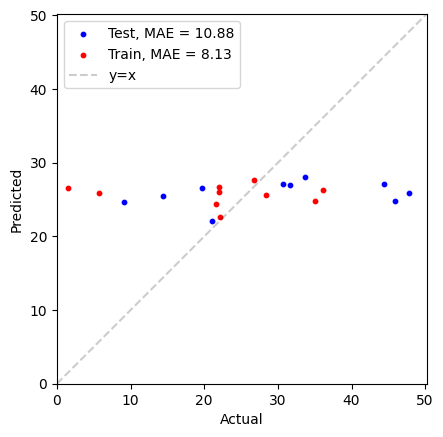

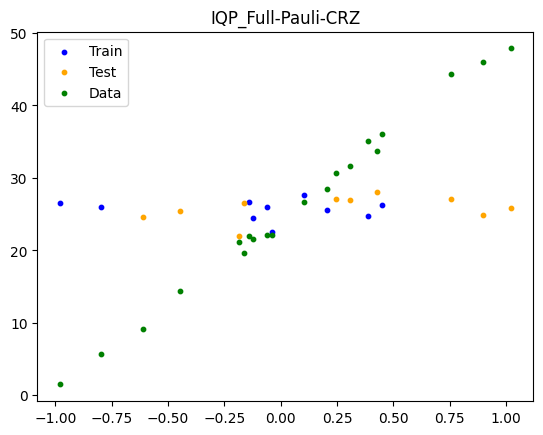

In [8]:

# removes temporary file created during training.
if os.path.exists(title + '_tentative_model.bin'):
    os.remove('tentative_model.bin')
elif os.path.exists('tentative_model.bin'):
    os.remove('tentative_model.bin')

scores, test_pred, train_pred = evaluate(model, X_train, y_train, X_test, y_test, plot=True, title=title,
                                         y_scaler=scaler)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

name = title + '_predicted_values.csv'
train_pred, y_train, test_pred, y_test = train_pred.tolist(), y_train.tolist(), test_pred.tolist(), y_test.tolist()
df_train = pd.DataFrame({'Predicted': train_pred, 'Reference': y_train})
df_train['Data'] = 'Train'
df_test = pd.DataFrame({'Predicted': test_pred, 'Reference': y_test})
df_test['Data'] = 'Test'
df = pd.concat([df_train, df_test], ignore_index=True)
df = df[['Data', 'Predicted', 'Reference']]

df.to_csv(name, index=False)
print(f'Saved predicted values as {name}')

print(f'Model scores: {scores}. ')

results = scores

if len(HYPERPARAMETERS['alpha']) != 1:
    results['hyperparameters'] = hyperparams
results_title = title + '_results.json'
with open(results_title, 'w') as outfile:
    json.dump(results, outfile)
    pass
print(f'Saved model results as {results_title}. ')
